# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from multiclass import SoftmaxClassifier
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (10.0, 7.0)
plt.rcParams["font.size"] = 16
plt.rcParams["font.family"] = "Serif"
plt.rcParams["grid.linestyle"] = "--"


In [2]:
DATA_DIR = 'data'
SAVE_DIR = "plots"

# Loading and Preprocessing

In [3]:
train = pd.read_csv(os.path.join(DATA_DIR, 'fashion-mnist_train.csv'))
test = pd.read_csv(os.path.join(DATA_DIR, 'fashion-mnist_test.csv'))

In [4]:
y = train["label"].values
X = train.drop("label", axis=1).values

test_y = test["label"].values
test = test.drop("label", axis=1).values

In [5]:
np.random.seed(42)
ratio = 0.7
ids = np.arange(X.shape[0])
np.random.shuffle(ids)
train_ids = ids[:int(ratio * X.shape[0])]
test_ids = ids[int(ratio * X.shape[0]):]
X_train, y_train = X[train_ids], y[train_ids]
X_test, y_test = X[test_ids], y[test_ids]

assert len(X_train) + len(X_test) == len(X)
assert len(X_train)>len(X_test)

## Normalizing the data

We can use the formula

$$
   X_{norm} = \frac{X - min(X)}{max(X) - min(X)}
$$

to normalize the data. However, a lot of values (pixels) in the image are 0 which are also the minimum values. This will cause problem with normalization. So, we'll normalize with the maximum value, which makes more sense in this situation.

In [6]:
X_train = X_train/255.0
X_test = X_test/255.0
test = test/255.0

## Plots

Let's plot some samples:

In [7]:
# Create dictionary of target classes
label_dict = {
 0: r"T-shirt",
 1: "Trouser",
 2: "Pullover",
 3: "Dress",
 4: "Coat",
 5: "Sandal",
 6: "Shirt",
 7: "Sneaker",
 8: "Bag",
 9: "Boot"
}

In [8]:
def plot_sample(X, y):
    """
    Displays the data from X. Plots images with corresponding labels in y.

    Parameters
    -----------
    X : array_like
        An array of shape (m, n) where m is the number of examples, and n is the
        number of features for each example.
    
    y : array_like
        An array of shape (m, ) that contains labels for X. Each value in y
    
    Instructions
    ------------
    Display in a grid of 10 by 10 the first 100 images from X. It is recommended
    that you pass just 100 images to this function.
    """
    plt.figure(figsize=(15, 15))
    for i in range(100):
        plt.subplot(10, 10, i + 1)
        plt.imshow(X[i, :].reshape(28, 28), cmap="binary")
        title = plt.title(label_dict[int(y[i])])
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(os.path.join(SAVE_DIR, "0601.png"))


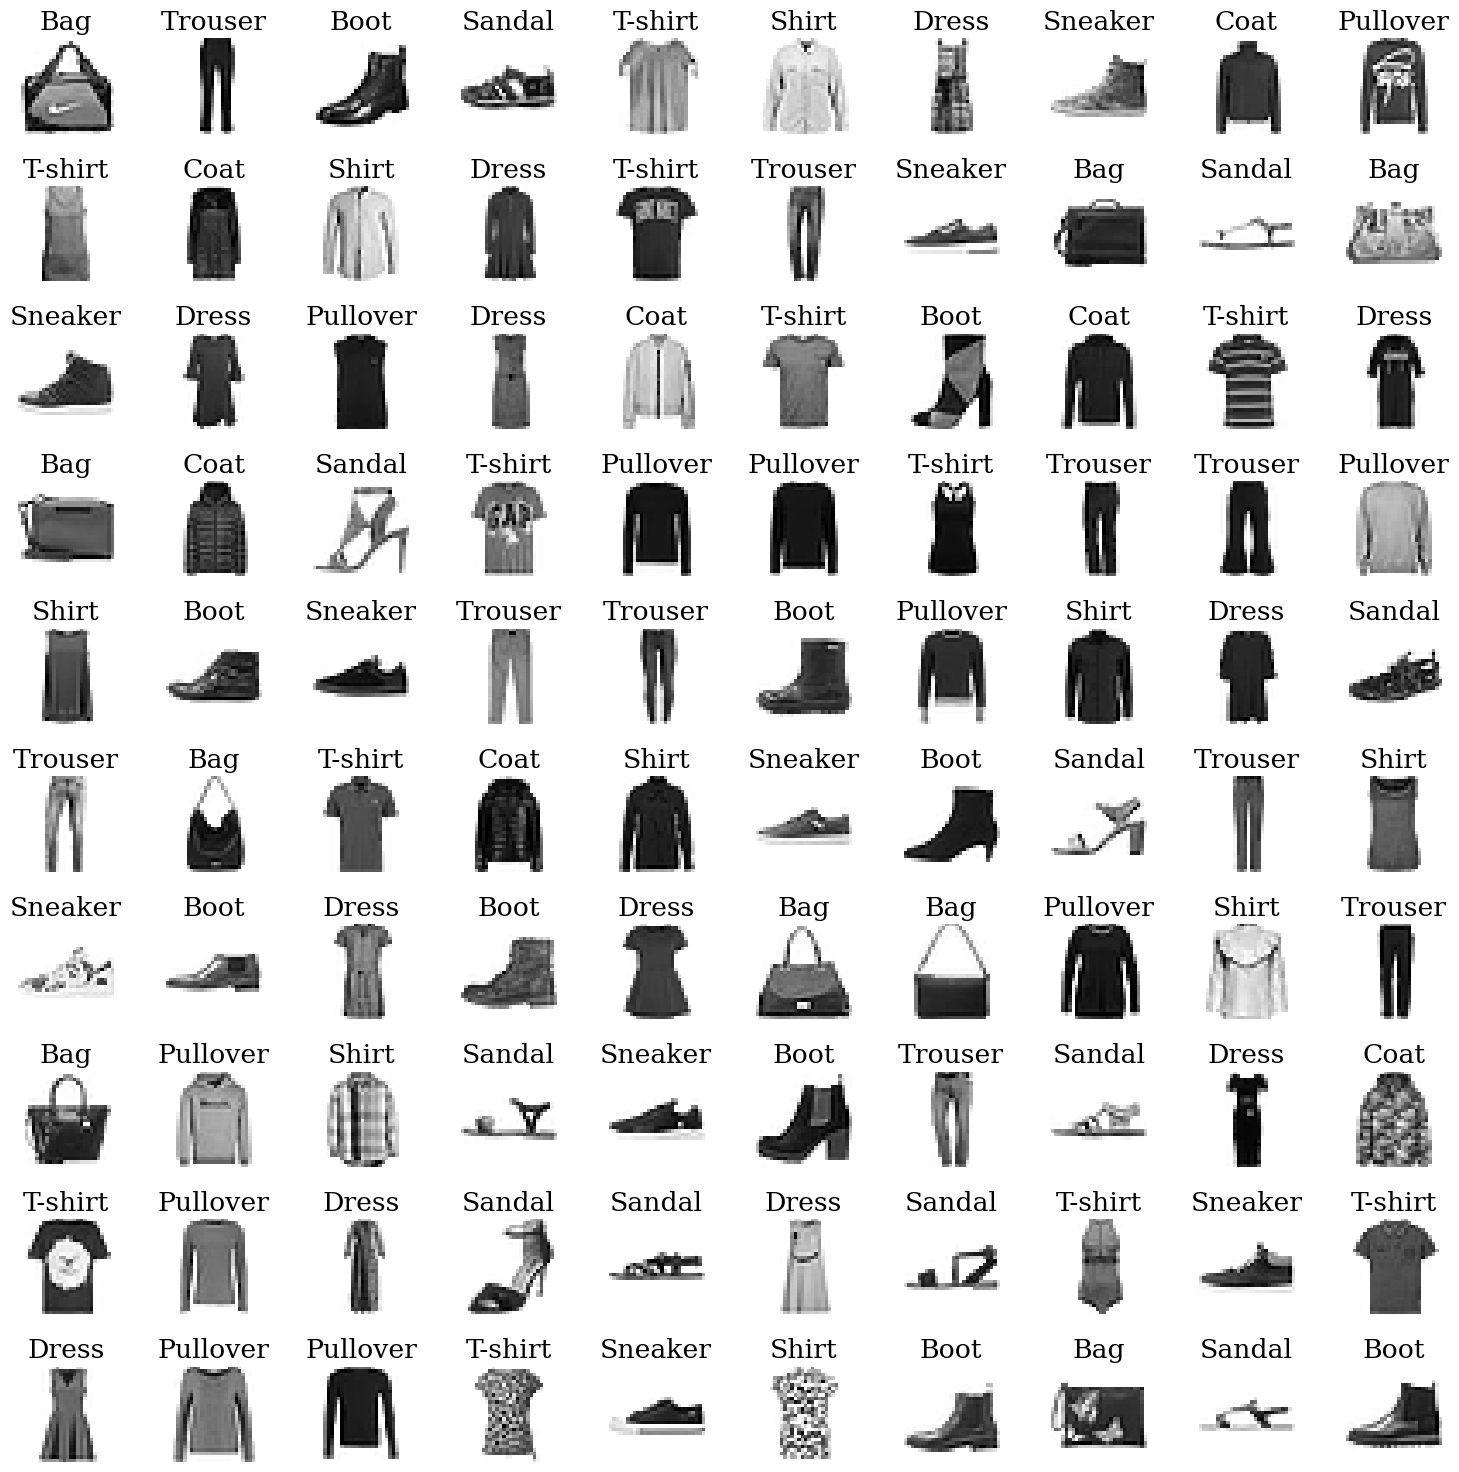

In [9]:
# Randomly select data points to display
m, _ = X.shape
rand_indices = np.random.choice(m, 100, replace=False)
X_sample = X[rand_indices, :]
y_sample = y[rand_indices]
d = plot_sample(X_sample, y_sample)

# Softmax Implementation

The idea behind using softmax is that we don't need to run our model a number of time before we can do any prediction. Using softmax allows us to do inference in just a single pass. Softmax is nothing but a mapping from a bunch of numbers to probability. It takes a vector and returns the probability corresponding to each row.

## Mathematical Formulation

The hypothesis function, for sigmoid regression has a form

$$
h(\theta) = \sigma(\mathbf{w}^TX) = y
$$

Here, $y$ is just a scalar.

Suppose there are $k$ classes, then, in softmax, the hypothesis function itself returns a vector with $\hat{y}\in \mathbb{R}^k$. That is,
$$
\mathbf{h(\theta)} = \text{softmax}(W^TX) = \hat{y}
$$

Note that I've written upper case $W$ instead of bold lower case $\mathbf{w}$ becuase in case of softmax, the weight is a matrix with dimension of $k\times n$.

The mathematical form of softmax is:
$$
 \phi(\mathbf{z}) = \frac{e^{\mathbf{z}}}{\sum_{j=1}^{k} e^{\mathbf{z}_{j}}}
$$
where
$$
\mathbf{z} = W^TX
$$

The loss function, used for softmax is the cross-entropy, defined as:
$$
J = -\sum_{c=1}^k {y}_{c}\log(\hat{y}_{c})
$$

The update equation is the same:

$$
W_j:= W_j - \alpha  \frac{\partial J}{\partial W_j}
$$

The update equation is similar to that in binary classification:
$$
\begin{aligned}
W:=W - \alpha \frac{1}{m} \sum_{i=1}^{m} (\hat{y}^{(i)} - \mathbf{y^{(i)}}) \mathbf{x}^{(i)}
\end{aligned}
$$

## Python Implemenation

The implementation of the softmax classification is given in the class `SoftmaxRegression` in the module `multiclass.py`. The class approach is used so that we can use some features which we implemented in the second assignment.

One more thing which we need to do is to one hot the labels. This is because, in case of softmax, the labels are not just a scalar but a vector. For example, if there are 3 classes, then the label for class 1 is `[1, 0, 0]`, for class 2 is `[0, 1, 0]` and for class 3 is `[0, 0, 1]`.

In [10]:
def one_hot(y, n_classes):
    """
    Converts a vector of labels into a one-hot matrix.

    Parameters
    ----------
    y : array_like
        An array of shape (m, ) that contains labels for X. Each value in y
        should be an integer in the range [0, n_classes).
    
    n_classes : int
        The number of classes.
    
    Returns
    -------
    one_hot : array_like
        An array of shape (m, n_classes) where each row is a one-hot vector.
    """
    m = y.shape[0]
    one_hot = np.zeros((m, n_classes))
    for i in range(m):
        one_hot[i, y[i]] = 1
    return one_hot

In [11]:
y_train_one_hot = one_hot(y_train, 10)
y_test_one_hot = one_hot(y_test, 10)

In [12]:
sc = SoftmaxClassifier(fit_intercept=True)
model = sc.fit(X_train, y_train_one_hot, epochs=30000, lr=0.2, verbose=0, tol=1e-6)

In [13]:
test_accuracy = sc.score(X_test, y_test)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))

train_accuracy = sc.score(X_train, y_train)
print("Train accuracy: {:.2f}%".format(train_accuracy * 100))

Test accuracy: 77.90%
Train accuracy: 82.23%


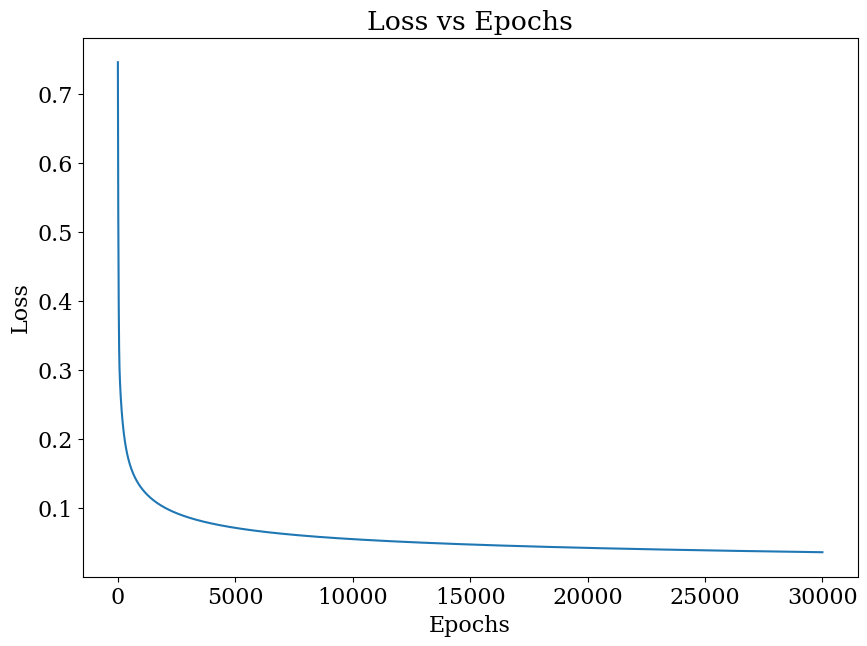

In [14]:
plt.plot(sc.losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.savefig(os.path.join(SAVE_DIR, "0602.png"))

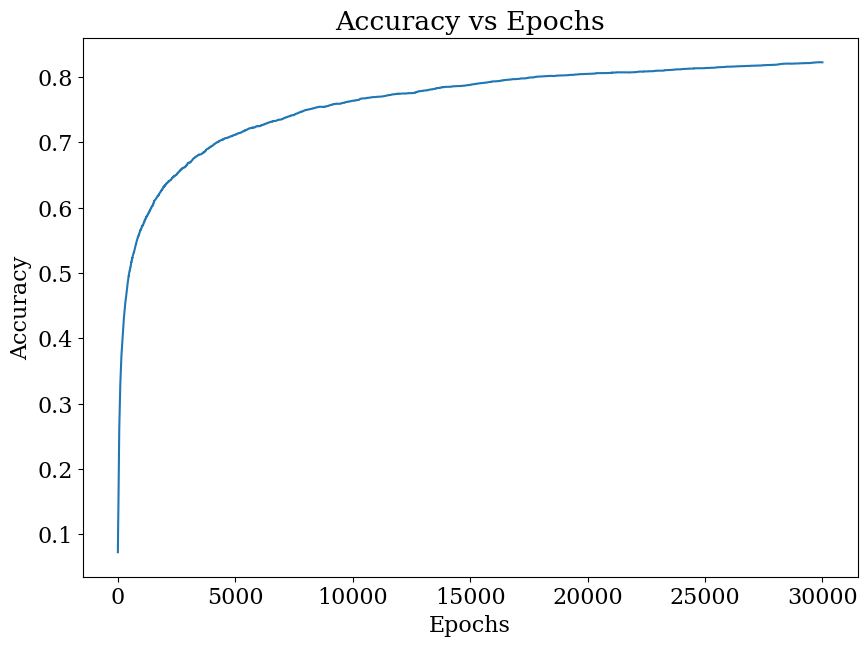

In [15]:
plt.plot(sc.scores)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.savefig(os.path.join(SAVE_DIR, "0603.png"))

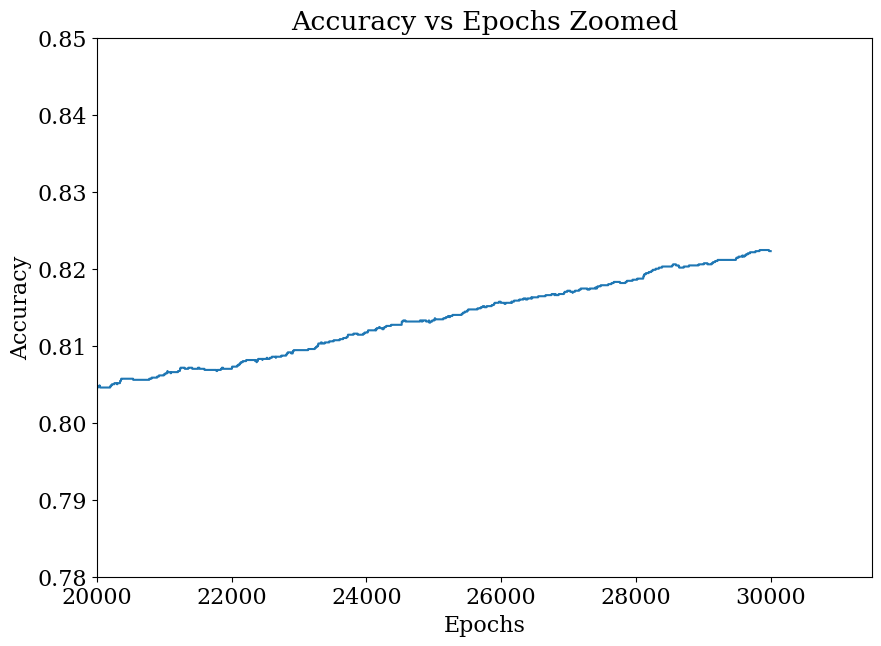

In [16]:
plt.plot(sc.scores)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs Zoomed")
plt.xlim(20000, )
plt.ylim(0.78, 0.85)
plt.savefig(os.path.join(SAVE_DIR, "0604.png"))

The accuracy is still increasing. Which means we can keep on training the loss will increase further.

## Comparison with One vs All

In the previous notebook, we used one vs all approach to do multiclass classification. The one vs all approach is a bit slower than softmax. This is because, in one vs all, we need to run the model multiple times. In softmax, we can do inference in just a single pass.

Here are the data for softmax and one vs all:

In [17]:
one_vs_all_train_acc = 0.9416
one_vs_all_test_acc = 0.8203

softmax_train_acc = train_accuracy
softmax_test_acc = test_accuracy

print("One vs all train accuracy: {:.2f}%".format(one_vs_all_train_acc * 100))
print("One vs all test accuracy: {:.2f}%".format(one_vs_all_test_acc * 100))
print("Softmax train accuracy: {:.2f}%".format(softmax_train_acc * 100))
print("Softmax test accuracy: {:.2f}%".format(softmax_test_acc * 100))

One vs all train accuracy: 94.16%
One vs all test accuracy: 82.03%
Softmax train accuracy: 82.23%
Softmax test accuracy: 77.90%


However, when it comes to accuracy, we see that the train accuracy for one vs all is better than that of softmax. This is because, in one vs all, we are using a different model for each class. So, the model is more specialized for each class. On the other hand, in softmax, we are using a single model for all the classes. So, the model is not specialized for each class.